In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt

In [2]:
# Fetching data

df = pd.read_csv('../data/dataset.csv')

<AxesSubplot:xlabel='Time'>

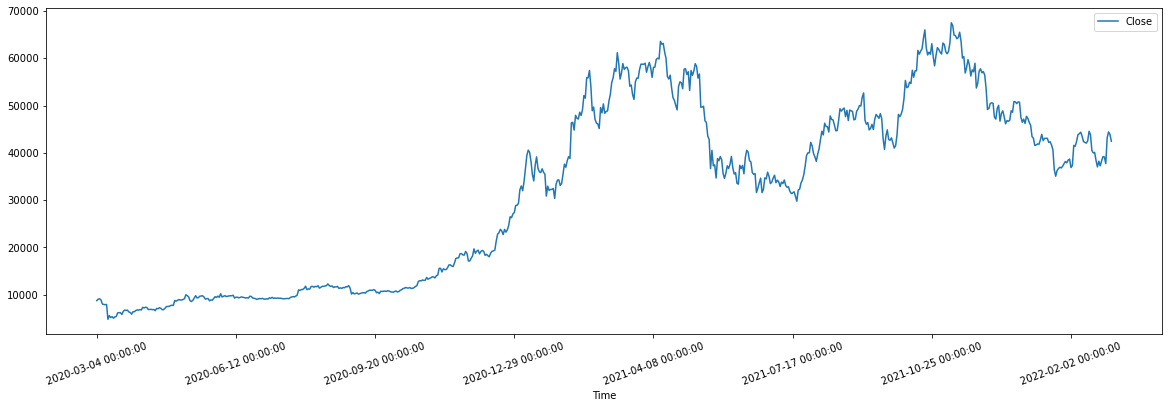

In [3]:
# Plotting btc prices
df.plot(x='Time', y='Close', kind='line', figsize=(20,6), rot=20)

## Feature Scaling

In [4]:
# Extracting closing prices
FullData=df[['Close']].values
print(FullData[0:5])
 
# Choosing between Standardization or normalization
sc = StandardScaler()
#sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Standardization###')
X[0:5]

[[8750.7]
 [9056.9]
 [9134.3]
 [8889.9]
 [8036.5]]
### After Standardization###


array([[-1.23101849],
       [-1.21479378],
       [-1.21069256],
       [-1.22364266],
       [-1.26886201]])

In [5]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set

In [6]:
num_cv = int(cv_size*len(X))
num_test = int(test_size*len(X))
num_train = len(X) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = X[:num_train]
cv = X[num_train:num_train+num_cv]
train_cv = X[:num_train+num_cv]
test = X[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 438
num_cv = 146
num_test = 146
train.shape = (438, 1)
cv.shape = (146, 1)
train_cv.shape = (584, 1)
test.shape = (146, 1)


In [7]:
# split into samples
def split(dataset):
    X_samples = list()
    y_samples = list()

    NumerOfRows = len(dataset)
    TimeSteps=5  # next day's Price Prediction is based on last how many past day's prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows , 1):
        x_sample = dataset[i-TimeSteps:i]
        y_sample = dataset[i]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    ################################################
    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data=np.array(X_samples)
    X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
    print('\n#### Input Data shape ####')
    print(X_data.shape)

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data=np.array(y_samples)
    y_data=y_data.reshape(y_data.shape[0], 1)
    print('\n#### Output Data shape ####')
    print(y_data.shape)
    
    return X_data, y_data

## Data Split

In [8]:
X_train, y_train = split(train)
X_cv, y_cv = split(cv)
X_train_cv, y_train_cv = split(train_cv)
X_test, y_test = split(test)


#### Input Data shape ####
(433, 5, 1)

#### Output Data shape ####
(433, 1)

#### Input Data shape ####
(141, 5, 1)

#### Output Data shape ####
(141, 1)

#### Input Data shape ####
(579, 5, 1)

#### Output Data shape ####
(579, 1)

#### Input Data shape ####
(141, 5, 1)

#### Output Data shape ####
(141, 1)


In [9]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 5
Number of Features: 1


In [10]:
def run(batchSize, numEpochs, X, Y, pred_set, actual_set):
    # Initialising the RNN
    regressor = Sequential()

    # Adding the First input hidden layer and the LSTM layer
    # return_sequences = True, means the output of every time step to be shared with hidden next layer
    regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

    # Adding the Second Second hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

    # Adding the Second Third hidden layer and the LSTM layer
    regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    ##################################################
    
    # Fitting the RNN to the Training set
    regressor.fit(X, Y, batch_size = batchSize, epochs = numEpochs)
    predicted_Price = regressor.predict(pred_set)
    predicted_Price = DataScaler.inverse_transform(predicted_Price)

    orig = actual_set
    orig = DataScaler.inverse_transform(actual_set)

    rmse = sqrt(mean_squared_error(orig, predicted_Price))
    mape = get_mape(orig, predicted_Price)
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [11]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Parameter

In [12]:
# vary training batches
param_label = 'epochs'
param_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(1, param, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

Epoch 1/100
433/433 [==============================] - 4s 4ms/step - loss: 0.3641
Epoch 2/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0164
Epoch 3/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0137
Epoch 4/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0134
Epoch 5/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0135
Epoch 6/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0132
Epoch 7/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 8/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0121
Epoch 9/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0119
Epoch 10/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0134
Epoch 11/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0112
Epoch 12/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0106
Epoch 13/100


433/433 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 98/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 99/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 100/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 101/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 102/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 103/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 104/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 105/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 106/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 107/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 108/200
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 10

433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 93/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 94/300
433/433 [==============================] - 2s 3ms/step - loss: 0.0049
Epoch 95/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 96/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 97/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 98/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 99/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 100/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 101/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 102/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 103/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 104/300

433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 287/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 288/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 289/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 290/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 291/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 292/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 293/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 294/300
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 295/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0046
Epoch 296/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 297/300
433/433 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 85/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 86/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0056
Epoch 87/400
433/433 [==============================] - 2s 4ms/step - loss: 0.0060
Epoch 88/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 89/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 90/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 91/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 92/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 93/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 94/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 95/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 96/400
433/

433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 279/400
433/433 [==============================] - 2s 4ms/step - loss: 0.0049
Epoch 280/400
433/433 [==============================] - 2s 3ms/step - loss: 0.0053
Epoch 281/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 282/400
433/433 [==============================] - 2s 4ms/step - loss: 0.0048
Epoch 283/400
433/433 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 284/400
433/433 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 285/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 286/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 287/400
433/433 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 288/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 289/400
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 

Epoch 73/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 74/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 75/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 76/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 77/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 78/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 79/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 80/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 81/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 82/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 83/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 84/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoc

433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 268/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9615
Epoch 269/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9620
Epoch 270/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 271/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 272/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 273/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 274/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9620
Epoch 275/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 276/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9620
Epoch 277/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 278/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 462/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9621
Epoch 463/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 464/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9621
Epoch 465/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9621
Epoch 466/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 467/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9622
Epoch 468/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9620
Epoch 469/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 470/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 471/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 472/500
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 157/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 158/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 159/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 160/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 161/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 162/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 163/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 164/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 165/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 166/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 167/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 

433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 351/600
433/433 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 352/600
433/433 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 353/600
433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 354/600
433/433 [==============================] - 2s 5ms/step - loss: 0.0046
Epoch 355/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 356/600
433/433 [==============================] - 2s 5ms/step - loss: 0.0046
Epoch 357/600
433/433 [==============================] - 2s 5ms/step - loss: 0.0048
Epoch 358/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 359/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 360/600
433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 361/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 545/600
433/433 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 546/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 547/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 548/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 549/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 550/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 551/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 552/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 553/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 554/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 555/600
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 140/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 141/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 142/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 143/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0053
Epoch 144/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 145/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 146/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 147/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 148/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 149/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 150/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 334/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 335/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 336/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 337/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 338/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 339/700
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 340/700
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 341/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 342/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 343/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 344/700
433/433 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 528/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 529/700
433/433 [==============================] - 2s 4ms/step - loss: 0.0034
Epoch 530/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 531/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 532/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 533/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 534/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 535/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 536/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 537/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 538/700
433/433 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 

433/433 [==============================] - 2s 5ms/step - loss: 0.9617
Epoch 22/800
433/433 [==============================] - 3s 6ms/step - loss: 0.9618
Epoch 23/800
433/433 [==============================] - 3s 6ms/step - loss: 0.9617
Epoch 24/800
433/433 [==============================] - 2s 5ms/step - loss: 0.9617
Epoch 25/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9615
Epoch 26/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9619
Epoch 27/800
433/433 [==============================] - 2s 5ms/step - loss: 0.9616
Epoch 28/800
433/433 [==============================] - 3s 6ms/step - loss: 0.9620
Epoch 29/800
433/433 [==============================] - 3s 6ms/step - loss: 0.9616
Epoch 30/800
433/433 [==============================] - 2s 5ms/step - loss: 0.9617
Epoch 31/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9619
Epoch 32/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9620
Epoch 33/800
433/

433/433 [==============================] - 2s 4ms/step - loss: 0.9619
Epoch 217/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9617
Epoch 218/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9615
Epoch 219/800
433/433 [==============================] - 2s 3ms/step - loss: 0.9618
Epoch 220/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9619
Epoch 221/800
433/433 [==============================] - 2s 5ms/step - loss: 0.9619
Epoch 222/800
433/433 [==============================] - 2s 5ms/step - loss: 0.9617
Epoch 223/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9616
Epoch 224/800
433/433 [==============================] - 2s 3ms/step - loss: 0.9619
Epoch 225/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9615
Epoch 226/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9617
Epoch 227/800
433/433 [==============================] - 2s 4ms/step - loss: 0.9619
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 411/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9622
Epoch 412/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 413/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 414/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 415/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 416/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 417/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 418/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 419/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 420/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 421/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 605/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 606/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 607/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 608/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 609/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 610/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9619
Epoch 611/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 612/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9620
Epoch 613/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 614/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 615/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9618
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.9616
Epoch 799/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9617
Epoch 800/800
433/433 [==============================] - 1s 3ms/step - loss: 0.9621
RMSE on train set = 18618.096
MAPE on train set = 41.524%
Epoch 1/900
433/433 [==============================] - 6s 4ms/step - loss: 0.3825
Epoch 2/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0182
Epoch 3/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0144
Epoch 4/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0134
Epoch 5/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0124
Epoch 6/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0121
Epoch 7/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0120
Epoch 8/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 9/900
433/433 [===========================

433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 194/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 195/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0054
Epoch 196/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 197/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 198/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 199/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 200/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 201/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 202/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 203/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 204/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 388/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 389/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 390/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 391/900
433/433 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 392/900
433/433 [==============================] - 27s 62ms/step - loss: 0.0045
Epoch 393/900
433/433 [==============================] - 2s 5ms/step - loss: 0.0043
Epoch 394/900
433/433 [==============================] - 4s 9ms/step - loss: 0.0044
Epoch 395/900
433/433 [==============================] - 3s 6ms/step - loss: 0.0044
Epoch 396/900
433/433 [==============================] - 4s 9ms/step - loss: 0.0042
Epoch 397/900
433/433 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 398/900
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoc

433/433 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 582/900
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 583/900
433/433 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 584/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 585/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 586/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 587/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 588/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 589/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 590/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 591/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 592/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 776/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 777/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 778/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0034
Epoch 779/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 780/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 781/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 782/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 783/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 784/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 785/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 786/900
433/433 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0057
Epoch 70/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0056
Epoch 71/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0068
Epoch 72/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0065
Epoch 73/1000
433/433 [==============================] - 2s 3ms/step - loss: 0.0059
Epoch 74/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0056
Epoch 75/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0056
Epoch 76/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0062
Epoch 77/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0060
Epoch 78/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 79/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 80/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0058
Epoch 

433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 262/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 263/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 264/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0051
Epoch 265/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 266/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 267/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 268/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 269/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 270/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0049
Epoch 271/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 272/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.

433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 454/1000
433/433 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 455/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 456/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 457/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 458/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 459/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 460/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 461/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0044
Epoch 462/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 463/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 464/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.

433/433 [==============================] - 2s 5ms/step - loss: 0.0040
Epoch 646/1000
433/433 [==============================] - 3s 6ms/step - loss: 0.0040
Epoch 647/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 648/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0042
Epoch 649/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 650/1000
433/433 [==============================] - 2s 6ms/step - loss: 0.0041
Epoch 651/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 652/1000
433/433 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 653/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 654/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 655/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 656/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.

433/433 [==============================] - 2s 5ms/step - loss: 0.0037
Epoch 838/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 839/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 840/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 841/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 842/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0038
Epoch 843/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.0036
Epoch 844/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 845/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0036
Epoch 846/1000
433/433 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 847/1000
433/433 [==============================] - 2s 5ms/step - loss: 0.0037
Epoch 848/1000
433/433 [==============================] - 2s 4ms/step - loss: 0.

,epochs,rmse,mape
0,100,1701.311521,3.203836
1,200,1968.525773,3.812979
2,300,1826.828491,3.621150
3,400,1927.293987,3.719000
4,500,18637.731318,41.576652
5,600,2774.436270,5.621663
6,700,2438.370312,4.656546
7,800,18618.095816,41.524210
8,900,2340.047564,4.425404
9,1000,2770.833297,5.162484


In [13]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 1701.312
optimum params = 100


In [14]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 3.204%
optimum params = 100


## Tuning Batch Size Parameter

In [15]:
# vary training batches
param_label = 'batch_size'
param_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
error_rate = {param_label: [], 'rmse': [], 'mape': []}

for param in param_list:
    rmse, mape = run(param, epoch_opt, X_train, y_train, X_cv, y_cv)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

Epoch 1/100
433/433 [==============================] - 5s 3ms/step - loss: 0.4919
Epoch 2/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0220
Epoch 3/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0183
Epoch 4/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0162
Epoch 5/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0138
Epoch 6/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0139
Epoch 7/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0134
Epoch 8/100
433/433 [==============================] - 2s 4ms/step - loss: 0.0133
Epoch 9/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0112
Epoch 10/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0123
Epoch 11/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 12/100
433/433 [==============================] - 1s 3ms/step - loss: 0.0111
Epoch 13/100


217/217 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 98/100
217/217 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 99/100
217/217 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 100/100
217/217 [==============================] - 1s 5ms/step - loss: 0.0054
RMSE on train set = 1985.436
MAPE on train set = 4.114%
Epoch 1/100
145/145 [==============================] - 4s 5ms/step - loss: 0.7291
Epoch 2/100
145/145 [==============================] - 1s 5ms/step - loss: 0.3254
Epoch 3/100
145/145 [==============================] - 1s 5ms/step - loss: 0.2816
Epoch 4/100
145/145 [==============================] - 1s 5ms/step - loss: 0.2444
Epoch 5/100
145/145 [==============================] - 1s 5ms/step - loss: 0.2117
Epoch 6/100
145/145 [==============================] - 1s 5ms/step - loss: 0.1827
Epoch 7/100
145/145 [==============================] - 1s 5ms/step - loss: 0.1573
Epoch 8/100
145/145 [=============================

109/109 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 94/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 95/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0052
Epoch 96/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 97/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 98/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0053
Epoch 99/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0048
Epoch 100/100
109/109 [==============================] - 1s 5ms/step - loss: 0.0050
RMSE on train set = 2191.045
MAPE on train set = 4.386%
Epoch 1/100
87/87 [==============================] - 4s 5ms/step - loss: 1.1091
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.7038
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0993
Epoch 4/100
87/87 [==============================] -

73/73 [==============================] - 0s 5ms/step - loss: 0.9612
Epoch 94/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9611
Epoch 95/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9614
Epoch 96/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9613
Epoch 97/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9612
Epoch 98/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9616
Epoch 99/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9613
Epoch 100/100
73/73 [==============================] - 0s 5ms/step - loss: 0.9611
RMSE on train set = 18708.133
MAPE on train set = 41.765%
Epoch 1/100
62/62 [==============================] - 4s 6ms/step - loss: 1.0627
Epoch 2/100
62/62 [==============================] - 0s 5ms/step - loss: 0.4933
Epoch 3/100
62/62 [==============================] - 0s 5ms/step - loss: 0.0591
Epoch 4/100
62/62 [==============================] - 0s 5ms/step -

55/55 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 94/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 95/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0052
Epoch 96/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 97/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 98/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 99/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 100/100
55/55 [==============================] - 0s 5ms/step - loss: 0.0059
RMSE on train set = 1901.633
MAPE on train set = 3.842%
Epoch 1/100
49/49 [==============================] - 4s 6ms/step - loss: 1.1462
Epoch 2/100
49/49 [==============================] - 0s 5ms/step - loss: 1.0508
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: 0.7146
Epoch 4/100
49/49 [==============================] - 0s 5ms/step - l

44/44 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 94/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 95/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 96/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 97/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 98/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 99/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 100/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0048
RMSE on train set = 2060.802
MAPE on train set = 4.206%


,batch_size,rmse,mape
0,1,1761.026575,3.361492
1,2,1985.435812,4.114396
2,3,1942.508791,3.797929
3,4,2191.044568,4.386052
4,5,2195.318720,4.492976
5,6,18708.133464,41.764623
6,7,1907.563175,3.814210
7,8,1901.633328,3.841516
8,9,2173.735279,4.337194
9,10,2060.802489,4.206139


In [16]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 1761.027
optimum params = 1


In [17]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 3.361%
optimum params = 1


## Model with the Optimal Params

In [18]:
# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train_cv, y_train_cv, batch_size = 5, epochs = 600)

predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)

orig=y_test
orig=DataScaler.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(orig, predicted_Price))
print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % get_mape(orig, predicted_Price))

Epoch 1/600
116/116 [==============================] - 5s 5ms/step - loss: 0.9385
Epoch 2/600
116/116 [==============================] - 1s 5ms/step - loss: 0.4611
Epoch 3/600
116/116 [==============================] - 1s 5ms/step - loss: 0.3053
Epoch 4/600
116/116 [==============================] - 1s 5ms/step - loss: 0.2578
Epoch 5/600
116/116 [==============================] - 1s 5ms/step - loss: 0.2194
Epoch 6/600
116/116 [==============================] - 1s 5ms/step - loss: 0.1878
Epoch 7/600
116/116 [==============================] - 1s 5ms/step - loss: 0.1609
Epoch 8/600
116/116 [==============================] - 1s 5ms/step - loss: 0.1383
Epoch 9/600
116/116 [==============================] - 1s 5ms/step - loss: 0.1193
Epoch 10/600
116/116 [==============================] - 1s 5ms/step - loss: 0.1026
Epoch 11/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0886
Epoch 12/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0761
Epoch 13/600


116/116 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 197/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 198/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 199/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 200/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 201/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 202/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 203/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 204/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0062
Epoch 205/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 206/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 207/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0064
Epoch 

116/116 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 391/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 392/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 393/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0063
Epoch 394/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0061
Epoch 395/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 396/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0065
Epoch 397/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 398/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 399/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0059
Epoch 400/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0058
Epoch 401/600
116/116 [==============================] - 1s 5ms/step - loss: 0.0060
Epoch 

116/116 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 585/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 586/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0060
Epoch 587/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0060
Epoch 588/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0057
Epoch 589/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 590/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0057
Epoch 591/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0057
Epoch 592/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 593/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 594/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 595/600
116/116 [==============================] - 1s 6ms/step - loss: 0.0059
Epoch 

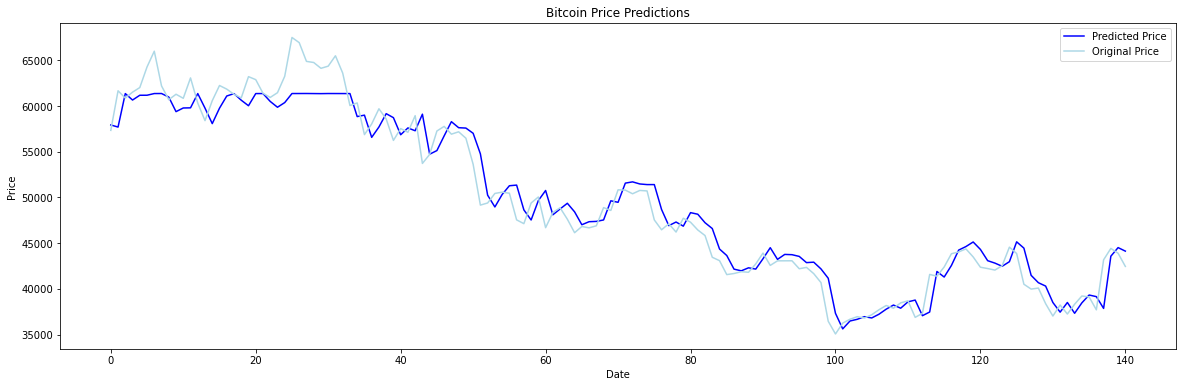

In [20]:
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Price')
plt.plot(orig, color = 'lightblue', label = 'Original Price')
 
plt.title('Bitcoin Price Predictions')
plt.xlabel('Date')
#plt.xticks(range(141), df.tail(141)['Time'])
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()